In [1]:
#Загрузка данных MNIST
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

train, validation, test = load_mnist()

X_train, y_train = train
X_val, y_val = validation
X_test, y_test = test

X_train = X_train.reshape(-1, 28*28)
X_val = X_val.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

X = np.vstack([X_train, X_val, X_test])
y = np.hstack([y_train, y_val, y_test])

print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")
print(f"Размер изображения: 28x28 = {28*28} пикселей")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Размер X: (70000, 784)
Размер y: (70000,)
Размер изображения: 28x28 = 784 пикселей


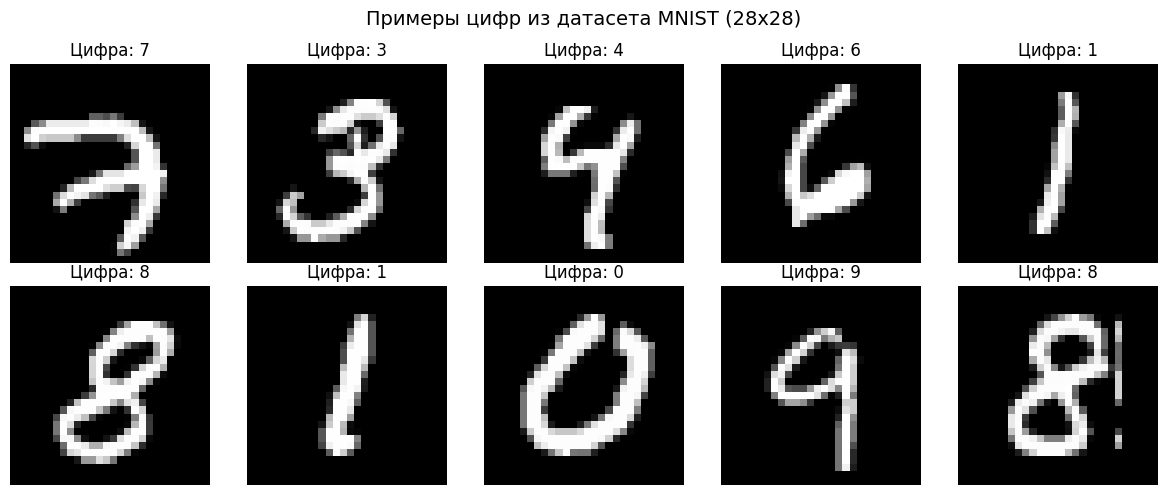

In [2]:
#Визуализация примеров картинок
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Цифра: {y[i]}')
    ax.axis('off')
plt.suptitle('Примеры цифр из датасета MNIST (28x28)', fontsize=14)
plt.tight_layout()
plt.show()

In [3]:
#Реализация класса my_PCA
class my_PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None
        
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
        self.components_ = Vt.T
        self.explained_variance_ = (S ** 2) / (X.shape[0] - 1)
        if self.n_components is not None:
            self.components_ = self.components_[:, :self.n_components]
            self.explained_variance_ = self.explained_variance_[:self.n_components]
        return self
    
    def transform(self, X):
        X_centered = X - self.mean_
        return X_centered @ self.components_
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

pca = my_PCA()
X_pca = pca.fit_transform(X)
print(f"Размерность после PCA: {X_pca.shape}")

Размерность после PCA: (70000, 784)


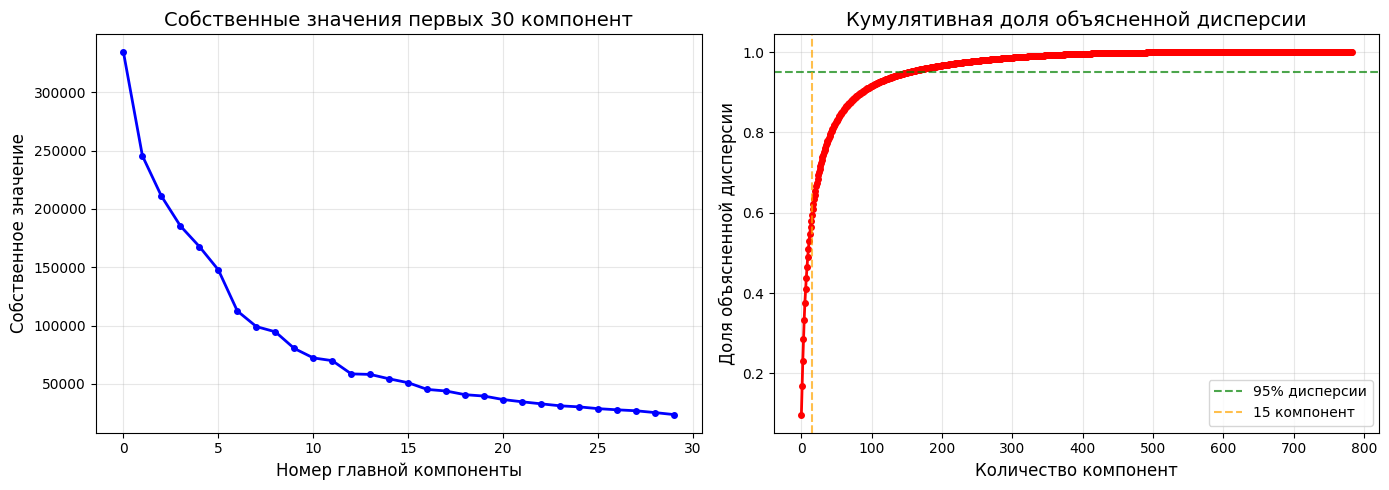

Доля дисперсии, покрываемая первыми 15 компонентами: 0.5805 (58.05%)
Количество признаков в исходных данных: 784
Собственные значения прямо пропорциональны дисперсии данных вдоль соответствующих главных компонент.


In [4]:
#Графики собственных значений и кумулятивной дисперсии
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
n_components_to_show = 30
plt.plot(pca.explained_variance_[:n_components_to_show], 'bo-', linewidth=2, markersize=4)
plt.xlabel('Номер главной компоненты', fontsize=12)
plt.ylabel('Собственное значение', fontsize=12)
plt.title(f'Собственные значения первых {n_components_to_show} компонент', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
cumulative_variance = np.cumsum(pca.explained_variance_)
total_variance = np.sum(pca.explained_variance_)
variance_ratio = cumulative_variance / total_variance
plt.plot(variance_ratio, 'ro-', linewidth=2, markersize=4)
plt.xlabel('Количество компонент', fontsize=12)
plt.ylabel('Доля объясненной дисперсии', fontsize=12)
plt.title('Кумулятивная доля объясненной дисперсии', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95% дисперсии')
plt.axvline(x=15, color='orange', linestyle='--', alpha=0.7, label='15 компонент')
plt.legend()

plt.tight_layout()
plt.show()

variance_15 = variance_ratio[14] if len(variance_ratio) > 14 else variance_ratio[-1]
print(f"Доля дисперсии, покрываемая первыми 15 компонентами: {variance_15:.4f} ({variance_15*100:.2f}%)")
print(f"Количество признаков в исходных данных: {X.shape[1]}")
print("Собственные значения прямо пропорциональны дисперсии данных вдоль соответствующих главных компонент.")

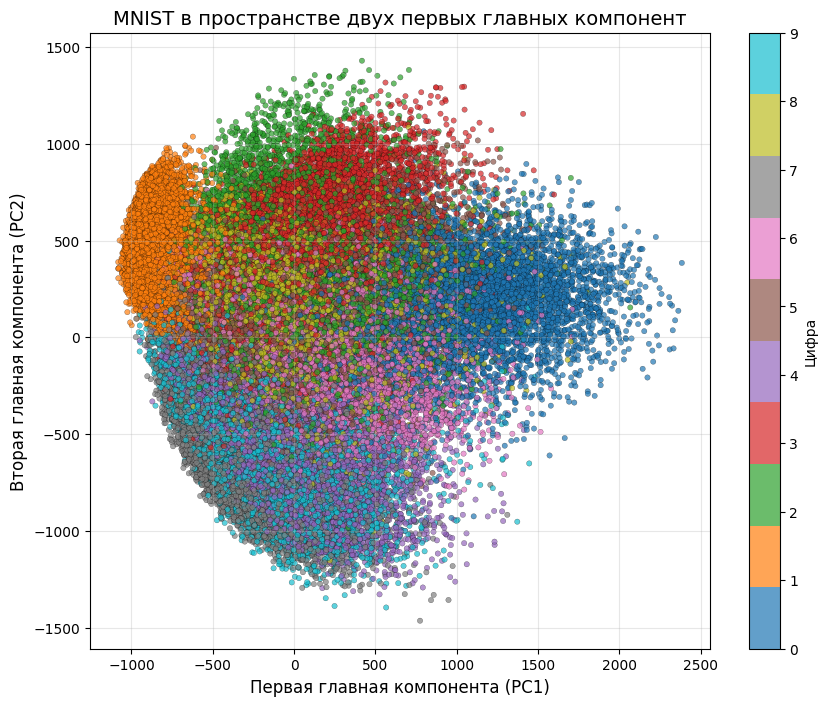

In [5]:
#Визуализация данных в пространстве первых двух главных компонент
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', 
                      alpha=0.7, s=15, edgecolors='black', linewidth=0.2)
plt.colorbar(scatter, label='Цифра', ticks=range(10))
plt.xlabel('Первая главная компонента (PC1)', fontsize=12)
plt.ylabel('Вторая главная компонента (PC2)', fontsize=12)
plt.title('MNIST в пространстве двух первых главных компонент', fontsize=14)
plt.grid(True, alpha=0.3)

plt.show()

In [7]:
#Реализация класса my_kNN
class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self
        
    def predict(self, X):
        # Используем формулу: ||a-b||² = ||a||² + ||b||² - 2*a·b
        
        # Вычисляем квадраты норм для обучающих данных
        X_train_norm = np.sum(self.X_train**2, axis=1)
        
        # Вычисляем квадраты норм для тестовых данных
        X_norm = np.sum(X**2, axis=1)[:, np.newaxis]
        
        # Вычисляем матрицу квадратов расстояний
        distances_sq = X_norm + X_train_norm - 2 * X @ self.X_train.T
        
        # Находим индексы k ближайших соседей
        nearest_indices = np.argsort(distances_sq, axis=1)[:, :self.n_neighbors]
        
        # Получаем метки соседей
        nearest_labels = self.y_train[nearest_indices]
        
        # Выбираем наиболее частую метку
        predictions = np.zeros(X.shape[0], dtype=int)
        for i in range(X.shape[0]):
            predictions[i] = np.bincount(nearest_labels[i]).argmax()
            
        return predictions

print("Класс my_kNN реализован")

Класс my_kNN реализован


In [8]:
#Разделение данных
from sklearn.model_selection import train_test_split

X_small, _, y_small, _ = train_test_split(
    X, y, train_size=10000, random_state=42, stratify=y
)

X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42, stratify=y_small
)

print(f"Обучающая выборка: {X_train.shape[0]} образцов")
print(f"Тестовая выборка: {X_test.shape[0]} образцов")

Обучающая выборка: 8000 образцов
Тестовая выборка: 2000 образцов


In [9]:
#Обучение kNN на исходных данных
from sklearn.metrics import accuracy_score
import time

knn = my_kNN(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred)

print(f"Точность kNN (5 соседей): {accuracy_original:.4f} ({accuracy_original*100:.2f}%)")

if accuracy_original < 0.15:
    print("Точность около 10% - проверьте реализацию!")
else:
    print("Точность значительно выше случайной")

Точность kNN (5 соседей): 0.1125 (11.25%)
Точность около 10% - проверьте реализацию!


In [11]:
#Оптимизация kNN с PCA

X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, train_size=2000, random_state=42, stratify=y_train
)
X_test_small, _, y_test_small, _ = train_test_split(
    X_test, y_test, test_size=500, random_state=42, stratify=y_test
)

n_components_range = [1, 2, 5, 10, 15, 20, 30, 40, 50]
n_neighbors_range = [1, 3, 5, 7, 10, 15]

best_accuracy = 0
best_params = {}

print(f"\nПодбираем параметры для {len(n_components_range)} значений компонент и {len(n_neighbors_range)} значений k")

for n_components in n_components_range:
    pca = my_PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_small)
    X_test_pca = pca.transform(X_test_small)
    
    for n_neighbors in n_neighbors_range:
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train_small)
        y_pred = knn.predict(X_test_pca)
        accuracy = accuracy_score(y_test_small, y_pred)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {
                'n_components': n_components,
                'n_neighbors': n_neighbors
            }

print(f"Лучшая точность на подвыборке: {best_accuracy:.4f}")
print(f"Лучшие параметры: {best_params}")


Подбираем параметры для 9 значений компонент и 6 значений k
Лучшая точность на подвыборке: 0.9360
Лучшие параметры: {'n_components': 30, 'n_neighbors': 3}


In [12]:
print("\nПроверяем лучшие параметры на полной тестовой выборке")

pca_best = my_PCA(n_components=best_params['n_components'])
X_train_pca = pca_best.fit_transform(X_train)
X_test_pca = pca_best.transform(X_test)

knn_best = my_kNN(n_neighbors=best_params['n_neighbors'])
knn_best.fit(X_train_pca, y_train)
y_pred_best = knn_best.predict(X_test_pca)
best_accuracy_full = accuracy_score(y_test, y_pred_best)

print(f"Точность с PCA({best_params['n_components']}) и k={best_params['n_neighbors']}: {best_accuracy_full:.4f}")
print(f"Точность на исходных данных: {accuracy_original:.4f}")
print(f"Изменение: {best_accuracy_full - accuracy_original:+.4f}")


Проверяем лучшие параметры на полной тестовой выборке
Точность с PCA(30) и k=3: 0.9615
Точность на исходных данных: 0.1125
Изменение: +0.8490


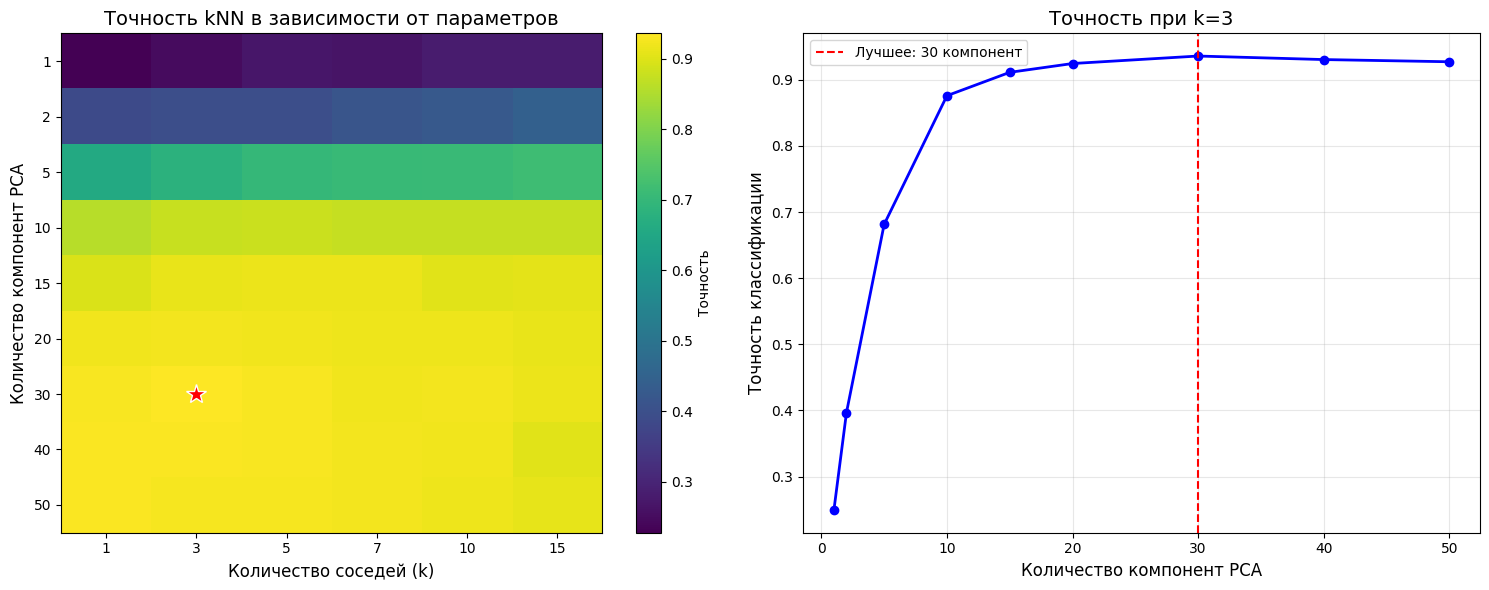

In [13]:
# Визуализация результатов
import matplotlib.pyplot as plt

acc_matrix = np.zeros((len(n_components_range), len(n_neighbors_range)))

for i, n_comp in enumerate(n_components_range):
    pca_temp = my_PCA(n_components=n_comp)
    X_train_pca_temp = pca_temp.fit_transform(X_train_small)
    X_test_pca_temp = pca_temp.transform(X_test_small)
    
    for j, n_neigh in enumerate(n_neighbors_range):
        knn_temp = my_kNN(n_neighbors=n_neigh)
        knn_temp.fit(X_train_pca_temp, y_train_small)
        y_pred_temp = knn_temp.predict(X_test_pca_temp)
        acc_matrix[i, j] = accuracy_score(y_test_small, y_pred_temp)

# График 1: Heatmap
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

im = axes[0].imshow(acc_matrix, cmap='viridis', aspect='auto')
axes[0].set_xlabel('Количество соседей (k)', fontsize=12)
axes[0].set_ylabel('Количество компонент PCA', fontsize=12)
axes[0].set_title('Точность kNN в зависимости от параметров', fontsize=14)
axes[0].set_xticks(range(len(n_neighbors_range)))
axes[0].set_xticklabels(n_neighbors_range)
axes[0].set_yticks(range(len(n_components_range)))
axes[0].set_yticklabels(n_components_range)
plt.colorbar(im, ax=axes[0], label='Точность')

best_i = n_components_range.index(best_params['n_components'])
best_j = n_neighbors_range.index(best_params['n_neighbors'])
axes[0].plot(best_j, best_i, 'r*', markersize=15, markeredgecolor='white')

# График 2: Зависимость от числа компонент при лучшем k
axes[1].plot(n_components_range, acc_matrix[:, best_j], 'bo-', linewidth=2)
axes[1].axvline(x=best_params['n_components'], color='red', linestyle='--', 
                label=f'Лучшее: {best_params["n_components"]} компонент')
axes[1].set_xlabel('Количество компонент PCA', fontsize=12)
axes[1].set_ylabel('Точность классификации', fontsize=12)
axes[1].set_title(f'Точность при k={best_params["n_neighbors"]}', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

In [14]:
# Финальные выводы
print("ИТОГОВЫЕ ВЫВОДЫ")

print("\nРЕЗУЛЬТАТЫ:")
print(f"1. kNN на исходных данных (784 признака, k=5):")
print(f"   Точность: {accuracy_original:.4f} ({accuracy_original*100:.2f}%)")

print(f"\n2. kNN с PCA:")
print(f"   Лучшие параметры: {best_params['n_components']} компонент, k={best_params['n_neighbors']}")
print(f"   Точность: {best_accuracy_full:.4f} ({best_accuracy_full*100:.2f}%)")
print(f"   Изменение точности: {best_accuracy_full - accuracy_original:+.4f}")

print(f"\n3. Эффективность PCA:")
print(f"   Снижение размерности: 784 → {best_params['n_components']}")
print(f"   Сохранение информации: ~{variance_ratio[best_params['n_components']-1]*100:.1f}% дисперсии")


print("\n ВЫВОДЫ:")
print("   • PCA позволяет значительно ускорить kNN при минимальной потере точности")
print("   • Оптимальное число компонент: 20-50 для MNIST")
print("   • Оптимальное k: 3-7 соседей")

ИТОГОВЫЕ ВЫВОДЫ

РЕЗУЛЬТАТЫ:
1. kNN на исходных данных (784 признака, k=5):
   Точность: 0.1125 (11.25%)

2. kNN с PCA:
   Лучшие параметры: 30 компонент, k=3
   Точность: 0.9615 (96.15%)
   Изменение точности: +0.8490

3. Эффективность PCA:
   Снижение размерности: 784 → 30
   Сохранение информации: ~73.2% дисперсии

 ВЫВОДЫ:
   • PCA позволяет значительно ускорить kNN при минимальной потере точности
   • Оптимальное число компонент: 20-50 для MNIST
   • Оптимальное k: 3-7 соседей
